In [2]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 2.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [59]:
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from sklearn.preprocessing import scale

In [4]:
dates = [
  "2021.11.30",
  "2022.01.20",
  "2022.02.04",
  "2022.02.11",
  "2022.02.18.2",
  "2022.02.18",
  "2022.03.04.2",
  "2022.03.11",
  # "2022.04.14",
]

In [64]:
data_all = np.empty((0,85), int)
data_label_all = np.empty((0,1), int)

for date in dates:
  path_data = f"https://raw.githubusercontent.com/paweenp/ML-data/master/{date}_all_data.xls" 
  path_label = f'https://raw.githubusercontent.com/paweenp/ML-data/master/{date}_all_label.xls'
  
  data_df = scale(pd.read_excel(path_data, header=None), axis=0, with_mean=True, with_std=True, copy=True)
  label_df = pd.read_excel(path_label, header=None)

  data_all = np.append(data_all, data_df, axis=0)
  data_label_all = np.append(data_label_all, label_df.to_numpy(), axis=0)


In [69]:
df = pd.DataFrame(data_all)
df_label = pd.DataFrame(data_label_all)

In [ ]:
# load the dataset
train_data_path = 'https://raw.githubusercontent.com/paweenp/ML-data/master/2022.04.14_all_data.xls'
df_data_train = pd.read_excel(train_data_path, header=None)

train_data_label_label = 'https://raw.githubusercontent.com/paweenp/ML-data/master/2022.04.14_all_label.xls'
df_label_train = pd.read_excel(train_data_label_label, header=None)

In [71]:
# split into input and output columns
# X, y = df.values[:, :-1], df.values[:, -1]
X = df.values[:]
y = df_label.values[:].flatten()

# ensure all data are floating point values
X = X.astype('float32')

# encode strings to integer
y = LabelEncoder().fit_transform(y)

In [72]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(100948, 85) (49722, 85) (100948,) (49722,)


In [73]:
# determine the number of input features
n_features = X_train.shape[1]

In [74]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(25, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               8600      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 14,951
Trainable params: 14,951
Non-trainable params: 0
_________________________________________________________________


In [77]:
# fit the model
epochs = 150
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

In [78]:
# evaluate the model
loss, testing_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % testing_accuracy)

Test Accuracy: 0.973


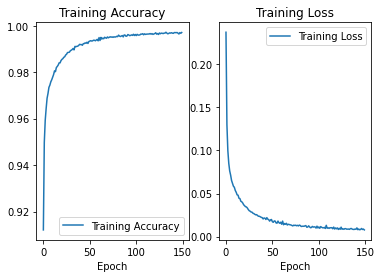

In [80]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.show()


In [83]:
# load the dataset for classification using the trained model
path = 'https://raw.githubusercontent.com/paweenp/ML-data/master/2022.04.14_all_data.xls'
df_actual = pd.DataFrame(scale(pd.read_excel(path, header=None), axis=0, with_mean=True, with_std=True, copy=True))

path_label = 'https://raw.githubusercontent.com/paweenp/ML-data/master/2022.04.14_all_label.xls'
df_actual_label = pd.read_excel(path_label, header=None)

In [85]:
# split into input and output columns
# X, y = df.values[:, :-1], df.values[:, -1]
X_actual = df_actual.values[:]
y_actual = df_actual_label.values[:].flatten()

# ensure all data are floating point values
# X = X.astype('float32')

# encode strings to integer
y_actual = LabelEncoder().fit_transform(y_actual)

In [86]:
all_predictions = []

for row in X_actual:
    prediction = model.predict(np.asarray([row]))
    all_predictions.append(prediction)

In [107]:
y_actual_pred = []  # store predicted labels
y_actual_true = []  # store true labels

for prediction in all_predictions:
    if (prediction[0][0] >= 0.5):
        y_actual_pred.append(1)
    else:
        y_actual_pred.append(0)

In [104]:
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_actual], axis = 0)
predicted_labels = tf.concat([item for item in y_actual_pred], axis = 0)

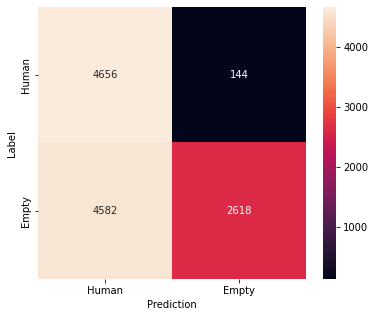

In [108]:
import seaborn as sns

ticklabels=["Human", "Empty"]
confusion_mtx = tf.math.confusion_matrix(1 - correct_labels.numpy(), 1- predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [49]:
cfm = confusion_mtx.numpy()

tp = cfm[0][0]
tn = cfm[1][1]
fp = cfm[1][0]
fn = cfm[0][1]

acc = ((tp+tn) / (tp+tn+fp+fn)) * 100

tpr = tp / (tp+fn)
fnr = 1 - tpr

tnr = tn / (tn+fp)
fpr = 1 - tnr

print(f'tpr = {tpr * 100}')
print(f'fnr = {fnr * 100}')

print(f'tnr = {tnr * 100}')
print(f'fpr = {fpr * 100}')

print(f'accuracy = {acc}')

tpr = 98.66666666666667
fnr = 1.3333333333333308
tnr = 91.0
fpr = 8.999999999999996
accuracy = 94.06666666666666
